In [1]:
# from dask.distributed import Client, LocalCluster
# import logging

# cluster = LocalCluster(
#     n_workers=28,
#     threads_per_worker=8,
#     silence_logs=logging.DEBUG
# )

# client = Client(cluster, heartbeat_interval=10000)

# print(client.dashboard_link)

In [14]:
import afqinsight as afqi
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pickle
import seaborn as sns

from datetime import datetime

from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.linear_model import LassoCV

from neurocombat_sklearn import CombatModel

from skopt import BayesSearchCV
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

print(afqi.__version__)

0.2.9.dev2565515056


In [3]:
# with open("hbn_regression_pure_lasso.pkl", "rb") as fp:
#     results = pickle.load(fp)

In [5]:
X, y, groups, columns, group_names, subjects, classes = afqi.load_afq_data(
    "../data/raw/hbn_data",
    target_cols=["Age"],
    index_col="EID"
)

In [6]:
print(X.shape)
print(len(subjects))

(2085, 3600)
2085


In [7]:
df_y = pd.read_csv("../data/raw/hbn_data/9994_Basic_Demos_20210329.csv").drop(axis="rows", index=0)
df_y = df_y[["EID", "Age"]]
df_y = df_y.set_index("EID", drop=True)

df_subs = pd.DataFrame(index=subjects).merge(df_y, how="left", left_index=True, right_index=True)
df_subs = df_subs[~df_subs.index.duplicated(keep="first")]
print(df_subs.shape)

y = df_subs["Age"].astype(np.float64).to_numpy()
nan_mask = np.logical_not(np.isnan(y))
y = y[nan_mask]
X = X[nan_mask, :]
subjects = list(np.array(subjects)[nan_mask])

(2085, 1)


In [8]:
print(X.shape)
print(y.shape)
print(len(subjects))

(1999, 3600)
(1999,)
1999


In [9]:
len(groups)

36

In [10]:
df_sites = pd.read_csv(
    "../data/raw/hbn_data/combined_tract_profiles-20210128.csv", usecols=["subjectID", "sessionID"]
).drop_duplicates().set_index("subjectID")

df_sites = pd.DataFrame(index=subjects).merge(
    df_sites, how="left", left_index=True, right_index=True
)

site_mask = np.logical_and(
    df_sites["sessionID"] != "HBNsiteSI",
    df_sites["sessionID"] != "HBNsiteCUNY"
).to_numpy()

df_sites = df_sites[site_mask]
X = X[site_mask]
y = y[site_mask]
subjects = list(np.array(subjects)[site_mask])

df_sites["site_idx"] = df_sites["sessionID"].map({"HBNsiteRU": 0, "HBNsiteCBIC": 1})
sites = df_sites["site_idx"].to_numpy()

print(X.shape)
print(y.shape)
print(len(subjects))
print(sites.shape)
print(df_sites.isna().sum())

(1651, 3600)
(1651,)
1651
(1651,)
sessionID    0
site_idx     0
dtype: int64


<AxesSubplot:>

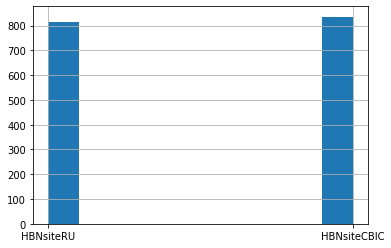

In [11]:
df_sites["sessionID"].hist()

In [12]:
def get_cv_results(n_repeats=5, n_splits=10,
                   power_transformer=False, 
                   shuffle=False,
                   ensembler=None,
                   target_transform_func=None,
                   target_transform_inverse_func=None,
                   n_estimators=10):
    if shuffle:
        rng = np.random.default_rng()
        y_fit = rng.permutation(y)
    else:
        y_fit = np.copy(y)
    
    groups_trim = [grp for grp in groups]
    X_trim = np.copy(X)
        
    cv = RepeatedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=1729
    )

    cv_results = {}
    
    pipe_skopt = afqi.pipeline.make_base_afq_pipeline(
        imputer_kwargs={"strategy": "median"},
        power_transformer=power_transformer,
        scaler="standard",
        estimator=LassoCV,
        estimator_kwargs={
            "verbose": 0,
            "n_alphas": 50,
            "cv": 3,
            "n_jobs": 28,
            "max_iter": 500,
        },
        verbose=0,
        ensemble_meta_estimator=ensembler,
        ensemble_meta_estimator_kwargs={
            "n_estimators": n_estimators,
            "n_jobs": 1,
            "oob_score": True,
            "random_state": 1729,
        },
        target_transform_func=target_transform_func,
        target_transform_inverse_func=target_transform_inverse_func,
    )

    for cv_idx, (train_idx, test_idx) in enumerate(cv.split(X_trim, y_fit)):
        start = datetime.now()

        X_train, X_test = X_trim[train_idx], X_trim[test_idx]
        y_train, y_test = y_fit[train_idx], y_fit[test_idx]
        sites_train, sites_test = sites[train_idx].reshape(-1, 1), sites[test_idx].reshape(-1, 1)

        imputer = SimpleImputer(strategy="median")
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        combat = CombatModel()
        X_train = combat.fit_transform(X_train_imputed, sites_train)
        X_test = combat.transform(X_test_imputed, sites_test)

        pipe_skopt.fit(X_train, y_train)

        cv_results[cv_idx] = {
            "pipeline": pipe_skopt,
            "train_idx": train_idx,
            "test_idx": test_idx,
            "y_pred": pipe_skopt.predict(X_test),
            "y_true": y_test,
            "test_mae": median_absolute_error(y_test, pipe_skopt.predict(X_test)),
            "train_mae": median_absolute_error(y_train, pipe_skopt.predict(X_train)),
            "test_r2": r2_score(y_test, pipe_skopt.predict(X_test)),
            "train_r2": r2_score(y_train, pipe_skopt.predict(X_train)),
        }
        
        if ensembler is None:
            if ((target_transform_func is not None)
                or (target_transform_inverse_func is not None)):
                cv_results[cv_idx]["coefs"] = pipe_skopt.named_steps["estimate"].regressor_.coef_
                cv_results[cv_idx]["alpha"] = pipe_skopt.named_steps["estimate"].regressor_.alpha_
            else:
                cv_results[cv_idx]["coefs"] = pipe_skopt.named_steps["estimate"].coef_
                cv_results[cv_idx]["alpha"] = pipe_skopt.named_steps["estimate"].alpha_
        else:
            if ((target_transform_func is not None)
                or (target_transform_inverse_func is not None)):
                cv_results[cv_idx]["coefs"] = [
                    est.coef_ for est
                    in pipe_skopt.named_steps["estimate"].regressor_.estimators_
                ]
                cv_results[cv_idx]["alpha"] = [
                    est.alpha_ for est
                    in pipe_skopt.named_steps["estimate"].regressor_.estimators_
                ]
            else:
                cv_results[cv_idx]["coefs"] = [
                    est.coef_ for est
                    in pipe_skopt.named_steps["estimate"].estimators_
                ]
                cv_results[cv_idx]["alpha"] = [
                    est.alpha_ for est
                    in pipe_skopt.named_steps["estimate"].estimators_
                ]

        print(f"CV index [{cv_idx:3d}], Elapsed time: ", datetime.now() - start)
        
    return cv_results, y_fit

In [15]:
results = {}

results[f"bagging_pure_lasso"] = get_cv_results(
    n_splits=5, n_repeats=1, power_transformer=False, shuffle=False
)

results[f"bagging_target_transform_pure_lasso"] = get_cv_results(
    n_splits=5, n_repeats=1, power_transformer=False, shuffle=False,
    target_transform_func=np.log, target_transform_inverse_func=np.exp
)

/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1727924294550576, tolerance: 1.1077817790771134
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.486569950442572, tolerance: 1.064759217026887
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6468692908683806, tolerance: 1.078179319022185
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

CV index [  0], Elapsed time:  0:01:29.405199


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3278474913522587, tolerance: 1.0726869263895082
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0403968704754334, tolerance: 1.0726869263895082
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0761114537617686, tolerance: 1.0704491270017857
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

CV index [  1], Elapsed time:  0:01:40.642978


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5751942194469848, tolerance: 1.0750230609979983
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2409614953612618, tolerance: 1.0540519980768919
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0351429330244173, tolerance: 1.0540519980768919
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

CV index [  2], Elapsed time:  0:01:46.413552


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1159951322797497, tolerance: 1.0930748934913403
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6201095395617813, tolerance: 1.084874637247335
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.396336568006518, tolerance: 1.084874637247335
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

CV index [  3], Elapsed time:  0:02:00.355221


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3595842279428325, tolerance: 1.0863348007983855
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6791596896987357, tolerance: 1.0926381548468362
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2417732007324958, tolerance: 1.0863348007983855
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

CV index [  4], Elapsed time:  0:02:11.299794


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009717548326712233, tolerance: 0.00942846540205181
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009979780110924708, tolerance: 0.00942846540205181
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01137676135635246, tolerance: 0.009424527996314191
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterat

CV index [  0], Elapsed time:  0:01:30.413798


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011671560788311552, tolerance: 0.00938373382661898
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010155835218800036, tolerance: 0.00938373382661898
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01455804614921874, tolerance: 0.009488933035104669
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterat

CV index [  1], Elapsed time:  0:01:57.106984


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01765472719258554, tolerance: 0.009204991700804261
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009677585140689615, tolerance: 0.009376140762522448
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04442457007743528, tolerance: 0.009204991700804261
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

CV index [  2], Elapsed time:  0:01:35.037907


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012358829792503911, tolerance: 0.009511845419277591
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017888973939903963, tolerance: 0.009511845419277591
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009695553208352692, tolerance: 0.009361075330781222
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite

CV index [  3], Elapsed time:  0:02:01.699705


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013684570479973956, tolerance: 0.009499574402682646
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012204870417132696, tolerance: 0.009499574402682646
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009546849540505775, tolerance: 0.009478935254970726
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite

CV index [  4], Elapsed time:  0:01:36.106185


In [19]:
results.keys()

dict_keys(['bagging_pure_lasso', 'bagging_target_transform_pure_lasso'])

In [20]:
for metric in ["test_mae", "test_r2", "train_mae", "train_r2"]:
    for key, res in results.items():
        mean_metric = [cvr[metric] for cvr in res[0].values()]
        print(metric, key, np.mean(mean_metric))
    
    print()

test_mae bagging_pure_lasso 1.546337581042667
test_mae bagging_target_transform_pure_lasso 1.422872508759431

test_r2 bagging_pure_lasso 0.5504692504659519
test_r2 bagging_target_transform_pure_lasso 0.5743935830149904

train_mae bagging_pure_lasso 1.2994449488830888
train_mae bagging_target_transform_pure_lasso 1.2118307607827414

train_r2 bagging_pure_lasso 0.6943510488741876
train_r2 bagging_target_transform_pure_lasso 0.6983936235864711



In [21]:
with open("hbn_regression_pure_lasso.pkl", "wb") as fp:
    pickle.dump(results, fp)